In [3]:
# Useful starting lines
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2
from helpers import *
from proj1_helpers import *
from costs import *
from implementations import *


## Load the training data into feature matrix, class labels, and event ids:

In [4]:

DATA_TRAIN_PATH = '../Data/train.csv' # TODO: add a file Data-Project1 with the train data 
y, tX, ids = load_csv_data(DATA_TRAIN_PATH)

# Preprocess the data

In [5]:
# Delete the outliers with the median
def delete_outliers(tX):
    for idx_feature in range(tX.shape[1]):
        tX_feature = tX[:,idx_feature]
        median = np.median(tX_feature[np.where(tX_feature != -999)])
        new = np.where(tX_feature == -999, median, tX_feature)
        tX[:, idx_feature] = np.copy(new)
    return tX

In [6]:
tX = delete_outliers(tX)

In [7]:
# Standardize the data
stx, mean_stx, std_x = standardize(tX)

In [8]:
# y must be 0 or 1 and not -1 or 1
def set_y(y):
    y = np.where(y == -1, 0, y)
    return y
y = set_y(y)

Get rid of the Features that do not provide any more information than the background

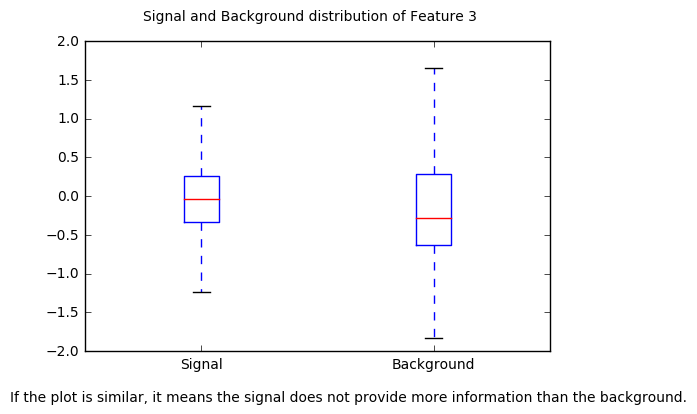

In [9]:
idx_f = 2
signal = stx[np.where(y == 1), idx_f + 1]
background = stx[np.where(y == 0), idx_f + 1]

plot = plt.figure()
plt.boxplot([signal, background], 0, '')
plt.xticks([1, 2], ['Signal', 'Background'])
plot.suptitle('Signal and Background distribution of Feature {f}'.format(f = idx_f + 1))

textvar = plot.text(0, 0, 'If the plot is similar, it means the signal does not provide more information than the background.')

# Remove Features

In [10]:
def calculate_correlation(stx):
    corr = np.ones((stx.shape[1]-1, stx.shape[1]-1))
    for feature1 in range(1, stx.shape[1]):
        for feature2 in range(1, stx.shape[1]):
            corr[feature1-1, feature2-1] = np.corrcoef(stx[:, feature1], stx[:, feature2])[0, 1]
            if (corr[feature1-1, feature2-1] >= 0.9 and feature1-1 != feature2-1):
                
                print("Features {f1} and {f2} are highly correlated: {corr}".format(f1 =feature1-1, f2 = feature2-1, corr = corr[feature1-1, feature2-1]))
    return corr

In [11]:
corr = calculate_correlation(stx)

Features 9 and 21 are highly correlated: 0.9044814595684958
Features 9 and 29 are highly correlated: 0.9656283889163997
Features 21 and 9 are highly correlated: 0.9044814595684957
Features 29 and 9 are highly correlated: 0.9656283889163997


In [12]:
idx_to_del = np.array([22, 30])

In [13]:
def calculate_correlation_with_y(stx, y, threshold):
    corr = np.ones(stx.shape[1]-1)
    for feature in range(1, stx.shape[1]):
        corr[feature-1] = np.corrcoef(y, stx[:, feature])[0, 1] 
        if (abs(corr[feature-1]) <= threshold):
            print("feature {f} is not correlated with y: {corr}".format(f = feature-1, corr= corr[feature-1]))
    return corr

In [14]:
corr = calculate_correlation_with_y(stx, y, 0.005)

feature 14 is not correlated with y: -0.0009432510582117535
feature 15 is not correlated with y: -0.00440253868638843
feature 17 is not correlated with y: 0.001516235377059733
feature 18 is not correlated with y: 0.00412544741152486
feature 24 is not correlated with y: 7.15909820593841e-05
feature 25 is not correlated with y: 0.0009043288374294407
feature 27 is not correlated with y: 0.0005721318815439868
feature 28 is not correlated with y: -0.003524581655021693


In [15]:
idx_to_del = np.append(idx_to_del, [ 15, 16, 18, 19, 25, 26, 28, 29])
#idx_to_del = np.append(idx_to_del, [ 15, 16, 18, 19, 21, 25, 26, 28, 29])

In [16]:
idx_to_del = np.sort(idx_to_del)
idx_to_del = idx_to_del[::-1]
print(idx_to_del)

[30 29 28 26 25 22 19 18 16 15]


In [17]:
def delete_features(stx):
    return np.delete(stx, idx_to_del, 1)

In [18]:
clean_tx = delete_features(np.copy(stx))
calculate_correlation_with_y(clean_tx, y, 0.005)

array([ 0.0263822 , -0.35142796, -0.01405527,  0.19252633,  0.20347244,
        0.21249463, -0.18361342,  0.01224548, -0.01528743,  0.15323593,
       -0.1953979 ,  0.27175188,  0.17514537,  0.23523798, -0.03194759,
        0.02246575,  0.00747534,  0.13354912,  0.11545223,  0.02287271])

## Build a polynomial basis

In [19]:
def build_poly(x, degree):
    """polynomial basis functions for input data x, for j=0 up to j=degree."""
    dim = degree+1
    N = x.shape[0]
    phi = np.ones((N, x.shape[1]))
    for j in range(1, dim):
        phi = np.concatenate((phi, np.power(x,j)), axis =1)
    return phi


In [21]:
degree = 2
poly_tx = build_poly(clean_tx, degree)
poly_tx.shape

(250000, 63)

# Validation

In [22]:
def divide_training_data(y, x, ratio ):
    """Divide a dataset into 2 disjoint parts. We will use this on the training data set 
    so that we can train on one and test on the other to check the accuracy of our prediction
    """
    indices = np.random.choice(np.arange(len(y)), int( len(y)*ratio ), replace=False)
    
    # training data 
    x_train = x[indices]
    y_train = y[indices]
    
    # test data 
    x_test = x[~indices]
    y_test = y[~indices]
    


    return x_train, x_test, y_train, y_test

In [23]:
def prediction( y, tX, gamma, max_iters, lambda_, initial_w  ):
    """Train on the train part of the data and test on the test part to validate the model"""
    x_train, x_test, y_train, y_test = divide_training_data(y, tX, 0.7 )
    
    loss = 0
    w = []
    loss, w = reg_logistic_regression( y_train, x_train, lambda_, gamma, max_iters )
    
    y_pred = predict_labels(w, x_test)    
    y_pred = set_y(y_pred)
    
    # accuracy of the prediction
    N = y_test.shape
    print(N, y_pred.shape)
    pred = np.sum(y_pred == y_test)/N[0]
        
    return pred

## Linear regression using Gradient Descent 

In [25]:
initial_w = np.zeros(stx.shape[1])
max_iters = 100
gamma = 0.001

least_squares_GD(y, stx, initial_w, max_iters, gamma)

(array([  3.26246845e-02,   1.12555408e-03,  -1.49630998e-02,
         -5.27639545e-04,   7.02221903e-03,   8.08978174e-03,
          8.11769979e-03,  -7.14295078e-03,   1.59108512e-03,
         -1.30569868e-03,   5.17468251e-03,  -8.33403032e-03,
          1.10322802e-02,   7.16516296e-03,   9.56867131e-03,
         -5.00683515e-05,  -2.02282621e-04,  -1.53553951e-03,
          4.60885699e-05,   1.85119866e-04,   1.08180533e-04,
          3.07448491e-04,   4.43231567e-03,   4.54581600e-03,
          3.71286308e-03,   2.90482476e-06,   3.16264988e-05,
          4.23474030e-05,   3.18010251e-05,  -1.40331564e-04,
          4.26636111e-03]), 0.15160026197005938)

## Linear regression using stochastic gradient descent

In [28]:
gamma = 0.1
least_squares_SGD(y, stx, initial_w, max_iters, gamma)

(array([  3.42652972e-01,  -6.82429969e-03,  -1.20053703e-01,
         -7.60258575e-02,   2.18634038e-02,   1.75429763e-02,
          4.13991244e-02,   5.07979004e-04,   1.05803005e-01,
         -1.41598873e-02,   1.71970141e-02,  -5.77982349e-02,
          6.24719504e-02,   3.63223883e-02,   8.38913851e-02,
          8.05147936e-06,  -6.45499390e-04,   8.15212555e-02,
         -3.26788905e-04,   1.22435912e-03,   3.35698968e-02,
          6.78002148e-05,  -1.80964935e-02,   4.56517065e-03,
         -2.20299761e-02,   9.16153743e-06,   6.01597954e-04,
         -1.35431395e-02,   1.08769143e-03,  -1.31712823e-03,
         -1.72333432e-02]), 0.085540862775766183)

## Least squares regression using normal equations

In [29]:
least_squares(y, stx)

(array([  3.42668000e-01,   6.11361314e-03,  -1.26533292e-01,
         -1.31728099e-01,   6.46217226e-03,   9.64026088e-03,
          5.20573141e-02,   3.57195511e-03,   1.40111528e-01,
         -1.38806755e-02,  -1.60323202e+02,  -9.38377506e-02,
          6.00765800e-02,   3.72963099e-02,   3.11465307e+01,
         -4.00142227e-04,  -4.05770496e-04,   3.07170376e+01,
         -3.26073105e-04,   1.27894398e-03,   5.01947429e-02,
          4.71663263e-04,  -2.39219337e-02,   2.73366768e-02,
         -1.86624775e-02,   2.92313230e-04,   1.24560590e-04,
         -9.10599047e-03,   7.58088080e-04,  -8.07604911e-04,
          1.35788484e+02]), 0.084989533074598111)

## Ridge regression using normal equations

In [33]:
lambda_ = 0.1
ridge_regression(y, stx, lambda_)

(array([  3.42667863e-01,   6.11297319e-03,  -1.26538540e-01,
         -1.31725593e-01,   6.46088980e-03,   9.63885056e-03,
          5.20609183e-02,   3.57572226e-03,   1.40110603e-01,
         -1.38823980e-02,   9.52716103e-03,  -9.38353284e-02,
          6.00747147e-02,   3.72989396e-02,   9.03488696e-02,
         -4.00598225e-04,  -4.05611588e-04,   1.41908324e-01,
         -3.25120523e-04,   1.27773001e-03,   5.01978869e-02,
          4.72869042e-04,  -2.39169434e-02,   2.73366514e-02,
         -1.86663923e-02,   2.92969358e-04,   1.24633015e-04,
         -9.10739964e-03,   7.57952288e-04,  -8.05691791e-04,
         -3.07741702e-02]), 0.084989820561928331)

## Logistic regression using gradient or SGD

In [35]:
max_iters = 100
gamma = 0.000001
logistic_regression(y, stx, initial_w, max_iters, gamma)

Current iteration=0, the loss=[ 173286.79513999]


(array([ -7.99164213e-01,  -3.82177695e-02,  -6.47271596e-01,
         -2.34822096e-01,   1.93134902e-01,   8.80119232e-02,
          2.13535323e-01,  -2.44198634e-02,   4.51242010e-01,
         -9.75654639e-02,   6.61573396e-02,  -2.70515076e-01,
          2.99966260e-01,   1.78630879e-01,   3.91223147e-01,
         -3.85215356e-03,  -5.28744162e-03,   2.44837602e-01,
         -1.89458727e-03,   6.87560818e-03,   4.90217893e-02,
          3.12141991e-03,  -4.31313227e-02,  -1.37513690e-02,
         -4.04791233e-02,   1.36205377e-04,   1.97982467e-03,
         -8.88506504e-02,   4.35008009e-03,  -2.93226649e-03,
         -6.64753884e-02]), array([ 127999.19292002]))

## Regularized  logistic  regression  using  gradient  descent or SGD

In [38]:
gamma = 5e-8
max_iters = 1000
lambda_ = 0.07
reg_logistic_regression(y, stx, lambda_, initial_w, max_iters, gamma)

Current iteration=0, the loss=[ 173286.79513999]
Current iteration=100, the loss=[ 150060.96001291]
Current iteration=200, the loss=[ 142037.96232546]
Current iteration=300, the loss=[ 137899.78894857]


KeyboardInterrupt: 

## Generate predictions and save ouput in csv format for submission:

In [151]:
DATA_TEST_PATH = '../Data/test.csv' # TODO: download train data and supply path here 
_, tX_test, ids_test = load_csv_data(DATA_TEST_PATH)

In [152]:
tX_test = delete_outliers(tX_test)


In [153]:
stx_test, mean_stx_test, std_x_test = standardize(tX_test)

In [154]:
clean_test = delete_features(stx_test)

In [155]:
poly_test = build_poly(clean_test, degree)
print(poly_test.shape)

(568238, 84)


In [157]:
OUTPUT_PATH = '../Data/Data_submission.csv' # TODO: fill in desired name of output file for submission
y_pred = predict_labels(w, poly_test)
create_csv_submission(ids_test, y_pred, OUTPUT_PATH)